# Subbundles Part 4: Adjacencies

**Subbundle** - a subgroup of streamlines with a set of common properties

In [1]:
from utils import *

import time
import os.path as op

from AFQ import api
import AFQ.data as afd

import numpy as np
import pandas as pd

from sklearn.metrics import r2_score

from dipy.io.streamline import load_tractogram
import dipy.tracking.streamline as dts

import matplotlib.pyplot as plt

/Users/bloomdt/anaconda/envs/subbundles/lib/python3.8/site-packages/dask/dataframe/utils.py:13: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Streamlines (from Part 2) and Streamline Profiles (from Part 3)

Streamlines are necessary to calculate mfd adjacency

## Distance/Adjacency Matrix of Streamline Correlations

An $N \times N$ matrix of coorelations of streamline tract profiles, where $N$ is the number of streamline profiles
  
  - **single matrix and single metric**
  
  - **single matrix and multiple metrics (weighted linear combination)**
    
    - manually stacked 
      
    - learn hyperparameters
      
  - *multiple matrices (tensor) and multiple metrics* (optional)

### Streamline Correlations

##### <span style="color:red">NOTE: There are multiple correlation metrics, using Pearson's r</span>

- <span style="color:red">**Question: are streamline profiles considered: measurement, ordinal, or categorical?**</span>

  - For now stick with Pearson's r

In [2]:
compare_test_retest = False
# compare_test_retest = True

test_retest_sessions = ['test', 'retest']
test_retest_names = ['HCP', 'HCP_retest']

In [3]:
# dataset_name = 'HCP'
dataset_name = 'HCP_retest'

In [4]:
# subjects = get_subjects(dataset_name)
# subjects = get_subjects_small(dataset_name)
# subjects = get_subjects_medium(dataset_name)
subjects = ['105923']

In [5]:
if compare_test_retest:
    print('HCP')
    myafq_test = get_afq('HCP')
    display(myafq_test.data_frame)
    
    print('HCP_retest')
    myafq_retest = get_afq('HCP_retest')
    display(myafq_retest.data_frame)
else:
    print(dataset_name)
    myafq = get_afq(dataset_name)
    display(myafq.data_frame)

HCP_retest


INFO:dipy.data.fetcher:Dataset is already in place. If you want to fetch it again please first remove the folder /Users/bloomdt/AFQ_data/templates 
INFO:dipy.data.fetcher:Dataset is already in place. If you want to fetch it again please first remove the folder /Users/bloomdt/AFQ_data/callosum_templates 


,subject,dwi_file,bvec_file,bval_file,custom_tract,reg_subject,ses,timing,sl_counts,results_dir,gtab,dwi_affine,dwi_img
0,103818,/Users/bloomdt/AFQ_data/hcp_retest/derivatives...,/Users/bloomdt/AFQ_data/hcp_retest/derivatives...,/Users/bloomdt/AFQ_data/hcp_retest/derivatives...,None,None,01,"{'Tractography': 0, 'Registration': 0, 'Segmen...",n_streamlines n_clean_streamline...,/Users/bloomdt/AFQ_data/hcp_retest/derivatives...,<dipy.core.gradients.GradientTable object at 0...,"[[-1.25, 0.0, 0.0, 90.0], [0.0, 1.25, 0.0, -12...",<class 'nibabel.nifti1.Nifti1Image'>\ndata sha...
1,105923,/Users/bloomdt/AFQ_data/hcp_retest/derivatives...,/Users/bloomdt/AFQ_data/hcp_retest/derivatives...,/Users/bloomdt/AFQ_data/hcp_retest/derivatives...,None,None,01,"{'Tractography': 0, 'Registration': 0, 'Segmen...",n_streamlines n_clean_streamline...,/Users/bloomdt/AFQ_data/hcp_retest/derivatives...,<dipy.core.gradients.GradientTable object at 0...,"[[-1.25, 0.0, 0.0, 90.0], [0.0, 1.25, 0.0, -12...",<class 'nibabel.nifti1.Nifti1Image'>\ndata sha...
2,111312,/Users/bloomdt/AFQ_data/hcp_retest/derivatives...,/Users/bloomdt/AFQ_data/hcp_retest/derivatives...,/Users/bloomdt/AFQ_data/hcp_retest/derivatives...,None,None,01,"{'Tractography': 0, 'Registration': 0, 'Segmen...",n_streamlines n_clean_streamline...,/Users/bloomdt/AFQ_data/hcp_retest/derivatives...,<dipy.core.gradients.GradientTable object at 0...,"[[-1.25, 0.0, 0.0, 90.0], [0.0, 1.25, 0.0, -12...",<class 'nibabel.nifti1.Nifti1Image'>\ndata sha...
3,114823,/Users/bloomdt/AFQ_data/hcp_retest/derivatives...,/Users/bloomdt/AFQ_data/hcp_retest/derivatives...,/Users/bloomdt/AFQ_data/hcp_retest/derivatives...,None,None,01,"{'Tractography': 0, 'Registration': 0, 'Segmen...",n_streamlines n_clean_streamline...,/Users/bloomdt/AFQ_data/hcp_retest/derivatives...,<dipy.core.gradients.GradientTable object at 0...,"[[-1.25, 0.0, 0.0, 90.0], [0.0, 1.25, 0.0, -12...",<class 'nibabel.nifti1.Nifti1Image'>\ndata sha...
4,115320,/Users/bloomdt/AFQ_data/hcp_retest/derivatives...,/Users/bloomdt/AFQ_data/hcp_retest/derivatives...,/Users/bloomdt/AFQ_data/hcp_retest/derivatives...,None,None,01,"{'Tractography': 0, 'Registration': 0, 'Segmen...",n_streamlines n_clean_streamline...,/Users/bloomdt/AFQ_data/hcp_retest/derivatives...,<dipy.core.gradients.GradientTable object at 0...,"[[-1.25, 0.0, 0.0, 90.0], [0.0, 1.25, 0.0, -12...",<class 'nibabel.nifti1.Nifti1Image'>\ndata sha...


In [6]:
# if compare_test_retest:
#     bundle_names = [*myafq_retest.bundle_dict]
# else:
#     bundle_names = [*myafq.bundle_dict]

# bundle_names = ['SLF_L', 'SLF_R']
# bundle_names = ['ARC_L', 'ARC_R', 'CST_L', 'CST_R', 'FP'] 
# bundle_names = ['SLF_L', 'SLF_R', 'ARC_L', 'ARC_R', 'CST_L', 'CST_R', 'FP']
bundle_names = ['SLF_R']

In [7]:
target_dirs = {}

for subject in subjects:
    target_dirs[subject] = {}
    
    if compare_test_retest:
        loc_test  = get_iloc(myafq_test, subject)
        loc_retest = get_iloc(myafq_retest, subject)
    else:
        loc = get_iloc(myafq, subject)

    for bundle_name in bundle_names:
        target_dirs[subject][bundle_name] = {}
        
        if compare_test_retest:
            iterables = zip(test_retest_names, test_retest_sessions, [myafq_test, myafq_retest], [loc_test, loc_retest])
        else:
            iterables = zip([''], [dataset_name], [myafq], [loc])

        for name, ses, myafq, loc in iterables:
            target_dir = get_dir_name(myafq, dataset_name, bundle_name, loc)
            target_dirs[subject][bundle_name][ses] = target_dir

##### <span style="color:red">NOTE: There are multiple python implementations to compute correlation</span>

- Haven't [compared or contrasted benefits](https://realpython.com/numpy-scipy-pandas-correlation-python/) of `NumPy`, `SciPy`, or `Pandas`

##### Candidiate [Correlation Coefficients](https://en.wikipedia.org/wiki/Correlation_coefficient#Types):

- Pearson's r

- [Rank correlation](https://en.wikipedia.org/wiki/Rank_correlation) coefficients

  - Spearman's $\rho$

  - Kendall's $\tau$
  
  - ...

##### FA (Fractional Anisotropy)

One of the scalars calculated from DWI.

More focus has been placed on FA since Schurr's paper indicates FA can be used to isolate SLF subbundles.

In [ ]:
fa_corrs = {}
for subject in subjects:
    fa_corrs[subject] = {}
    for bundle_name in bundle_names:
        fa_corrs[subject][bundle_name] = {}
        if compare_test_retest:
            iterables = zip(test_retest_names, test_retest_sessions)
        else:
            iterables = zip([''], [dataset_name])
            
        for name, ses in iterables:
            target_dir = target_dirs[subject][bundle_name][ses]
            f_name = op.join(target_dir,'adjacency_fa.npy')
            if op.isfile(f_name):
                fa_corrs[subject][bundle_name][ses] = np.load(f_name)

#### Absolute Difference in $\mu$ FA (mean Fractional Anisotropy)

Origially requested by Jason, but supplanted in favor of coefficient of determiniation since it also takes into account variance

#### Coefficient of Determination: $R^2$

In Schurr 2019 paper, main differentiating factors between SLFII and the other SLF sections are offsets in the mean FA between streamlines. 

Consider use a distance function that takes into account the offset, and not only co-variation, like:

https://scikit-learn.org/stable/modules/generated/sklearn.metrics.r2_score.html

##### examplar coefficent of determination

#### FA $R^2$

In [ ]:
fa_r2s = {}
for subject in subjects:
    fa_r2s[subject] = {}
    for bundle_name in bundle_names:
        fa_r2s[subject][bundle_name] = {}
        if compare_test_retest:
            iterables = zip(test_retest_names, test_retest_sessions)
        else:
            iterables = zip([''], [dataset_name])
            
        for name, ses in iterables:
            target_dir = target_dirs[subject][bundle_name][ses]
            f_name = op.join(target_dir,'adjacency_fa_r2.npy')
            if op.isfile(f_name):
                fa_r2s[subject][bundle_name][ses] = np.load(f_name)

#####   $\mu$-Reference  Warped FA $R^2$

The streamline profiles have been warped based on a reference streamline. Here the reference is a pseudo-streamline with the mean FA value across the bundle at each point.

In [ ]:
mean_warped_fa_r2s = {}
for subject in subjects:
    mean_warped_fa_r2s[subject] = {}
    for bundle_name in bundle_names:
        mean_warped_fa_r2s[subject][bundle_name] = {}
        if compare_test_retest:
            iterables = zip(test_retest_names, test_retest_sessions)
        else:
            iterables = zip([''], [dataset_name])
            
        for name, ses in iterables:
            target_dir = target_dirs[subject][bundle_name][ses]
            f_name = op.join(target_dir,'adjacency_ref_warped_fa_r2.npy')
            if op.isfile(f_name):
                mean_warped_fa_r2s[subject][bundle_name][ses] = np.load(f_name)

#####  Pairwise Warped FA $R^2$

In [ ]:
pairwise_warped_fa_r2s = {}
for subject in subjects:
    pairwise_warped_fa_r2s[subject] = {}
    for bundle_name in bundle_names:
        pairwise_warped_fa_r2s[subject][bundle_name] = {}
        if compare_test_retest:
            iterables = zip(test_retest_names, test_retest_sessions)
        else:
            iterables = zip([''], [dataset_name])
            
        for name, ses in iterables:
            target_dir = target_dirs[subject][bundle_name][ses]
            f_name = op.join(target_dir,'adjacency_pairwise_warped_fa_r2.npy')
            if op.isfile(f_name):
                pairwise_warped_fa_r2s[subject][bundle_name][ses] = np.load(f_name)

##### MD (Mean Diffusivity)

One of the scalars calculated from DWI

In [ ]:
md_corrs = {}
for subject in subjects:
    md_corrs[subject] = {}
    for bundle_name in bundle_names:
        md_corrs[subject][bundle_name] = {}
        if compare_test_retest:
            iterables = zip(test_retest_names, test_retest_sessions)
        else:
            iterables = zip([''], [dataset_name])
            
        for name, ses in iterables:
            target_dir = target_dirs[subject][bundle_name][ses]
            f_name = op.join(target_dir,'adjacency_md.npy')
            if op.isfile(f_name):
                md_corrs[subject][bundle_name][ses] = np.load(f_name)

### Distance Metrics

Given: 

- NxN streamlines 

Assuming:

- same subject

- same streamlines

Anything varies streamlines would violate assumptions:

- comparing subjects

- using different tractometry, segmentation, or metrics

Want:

- a distance metric that is similar to correlation

  - bounded between 0 and 1
  
  - 0 signifies streamlines are infinitely far apart
  
  - 1 signifies same streamline

Consider: 

- MDF between every pair

- Threshold distance $\theta$

  - If distance is greater than threshold then streamlines are considered infinitely far apart (not part of the same subbundle)

#### MDF (Minimum average Direct-Flip)

https://dipy.org/documentation/1.2.0./reference/dipy.segment/#bundles-distances-mdf

HCP_retest 105923 SLF_R 1.3212 seconds


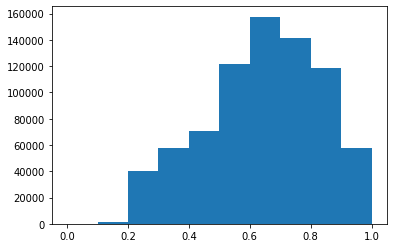

symmetric:  True
finite:  True
min:  0.0
max:  1.0
HCP_retest 105923 SLF_R is_mdf saving subbundles/HCP_retest/SLF_R/105923/01/adjacency_is_mdf.npy


In [70]:
mdfs = {}
is_mdfs = {}

for subject in subjects:
    mdfs[subject] = {}
    is_mdfs[subject] = {}

    for bundle_name in bundle_names:
        mdfs[subject][bundle_name] = {}
        is_mdfs[subject][bundle_name] = {}

        if compare_test_retest:
            iterables = zip(test_retest_names, test_retest_sessions)
        else:
            iterables = zip([''], [dataset_name])
            
        for name, ses in iterables:
            target_dir = target_dirs[subject][bundle_name][ses]
            f_name = op.join(target_dir,'adjacency_mdf.npy')

            if compare_test_retest:
                if op.isfile(f_name):
                    mdfs[subject][bundle_name][ses] = np.load(f_name)
                    print(name, subject, bundle_name, 'mdf', 'loading', f_name)
                
                f_name = op.join(target_dir,'adjacency_is_mdf.npy')

                if op.isfile(f_name):
                    is_mdfs[subject][bundle_name][ses] = np.load(f_name)
                    print(name, subject, bundle_name, 'is_mdf', 'loading', f_name)
            else:
                loc = get_iloc(myafq, subject)            
                tg_fname = get_tractogram_filename(myafq, bundle_name, loc)
                tractogram = load_tractogram(tg_fname, 'same')
                streamlines = tractogram.streamlines
                affine = tractogram.affine
                
                if len(streamlines) == 0:
                    print(dataset_name, subject, bundle_name, 'mdf', 'no streamlines')
                    continue

                fgarray = np.array(dts.set_number_of_points(streamlines, 100))
                            
                tic = time.perf_counter()
                mdf_np = dts.bundles_distances_mdf(fgarray, fgarray)
                # enforce symmetry (address numerical errors from mdf)
                mdf_np = (mdf_np + mdf_np.T) / 2
                mdf = pd.DataFrame(mdf_np)
                mdfs[subject][bundle_name][ses] = mdf

                # np.save(op.join(target_dir,'adjacency_mdf.npy'), mdf.to_numpy())
                
                ########## Investigating MDF symmetry ##########
                
#                 adjacency_test(mdf_np)
#                 print('mdf nonzero diff:', np.count_nonzero(mdf_np-mdf_np.T))
#                 print('mdf nonzero diff idx:', np.nonzero(mdf_np-mdf_np.T))
#                 print('mdf sum abs diff:', np.sum(abs(mdf_np-mdf_np.T)))
#                 print('mdf max abs diff:', np.max(abs(mdf_np-mdf_np.T)))
#                 i,j = np.unravel_index(np.argmax(abs(mdf_np-mdf_np.T), axis=None), abs(mdf_np-mdf_np.T).shape)
#                 print('mdf distances:\n', dts.bundles_distances_mdf([fgarray[i], fgarray[j]],[fgarray[i], fgarray[j]]))
#                 ax = plt.axes(projection='3d')
#                 ax.plot3D(fgarray[i,:,0],fgarray[i,:,1],fgarray[i,:,2], label=i)
#                 ax.plot3D(fgarray[j,:,0],fgarray[j,:,1],fgarray[j,:,2], label=j)
#                 plt.title('max asymmetric MDF')
#                 ax.legend()
#                 plt.show()
                
#                 np.save('max_asymmetric_mdf.npy', [fgarray[i], fgarray[j]])

#                 for i,j in np.transpose(np.nonzero(mdf_np-mdf_np.T)):
#                     print('mdf distances:\n', dts.bundles_distances_mdf([fgarray[i], fgarray[j]],[fgarray[i], fgarray[j]]))
#                     ax = plt.axes(projection='3d')
#                     ax.plot3D(fgarray[i,:,0],fgarray[i,:,1],fgarray[i,:,2], label=i)
#                     ax.plot3D(fgarray[j,:,0],fgarray[j,:,1],fgarray[j,:,2], label=j)
#                     plt.title('asymmetric MDF')
#                     ax.legend()
#                     plt.show()
#                     break
                    
                ########## Investigating MDF symmetry ##########


                # inverse scaled mdf (is_mdf)

                mdf_max = mdf.to_numpy().max()
                is_mdf = (mdf_max - mdf)
                is_mdf_max = is_mdf.to_numpy().max()
                is_mdf = is_mdf / is_mdf_max
                is_mdfs[subject][bundle_name][ses] = is_mdf
                toc = time.perf_counter()
                print(dataset_name, subject, bundle_name, f'{toc - tic:0.4f} seconds')
                
                adjacency_test(is_mdf)
                
                f_name = op.join(target_dir,'adjacency_is_mdf.npy')
                np.save(f_name, is_mdf.to_numpy())
                print(dataset_name, subject, bundle_name, 'is_mdf', 'saving', f_name)

### Maximum Asymmetry MDF for Defect

**TODO Open issue on dipy**

### Weighted Adjacencies

##### $\alpha$ FA + $\beta$ MD 

In [ ]:
fa_md_wts = {}
for subject in subjects:
    fa_md_wts[subject] = {}
    for bundle_name in bundle_names:
        fa_md_wts[subject][bundle_name] = {}
        if compare_test_retest:
            iterables = zip(test_retest_names, test_retest_sessions)
        else:
            iterables = zip([''], [dataset_name])
            
        for name, ses in iterables:
            fa_md_wts[subject][bundle_name][ses] = []
            target_dir = target_dirs[subject][bundle_name][ses]
            
            for alpha, beta in zip(alphas, betas):
                f_name = op.join(target_dir, f'adjacency_wt_{int(alpha*10)}_fa_{int(beta*10)}_md.npy')
                if op.isfile(f_name):
                    fa_md_wts[subject][bundle_name][ses].append(np.load(f_name))

##### $\alpha$ FA $R^2$ + $\beta$ MDF

In [ ]:
alphas = np.linspace(0,10,11)/10
betas = np.linspace(10,0,11)/10

far2_mdf_wts = {}
for subject in subjects:
    far2_mdf_wts[subject] = {}
    for bundle_name in bundle_names:
        far2_mdf_wts[subject][bundle_name] = {}
        if compare_test_retest:
            iterables = zip(test_retest_names, test_retest_sessions)
        else:
            iterables = zip([''], [dataset_name])
            
        for name, ses in iterables:
            far2_mdf_wts[subject][bundle_name][ses] = []
            target_dir = target_dirs[subject][bundle_name][ses]
            
            for alpha, beta in zip(alphas, betas):
                f_name = op.join(target_dir, f'adjacency_wt_{int(alpha*10)}_fa_r2_{int(beta*10)}_is_mdf.npy')
                if op.isfile(f_name):
                    far2_mdf_wts[subject][bundle_name][ses].append(np.load(f_name))

##### $\alpha$  $\mu$-Reference Warped FA $R^2$ + $\beta$ MDF

In [ ]:
alphas = np.linspace(0,10,11)/10
betas = np.linspace(10,0,11)/10

mean_warped_far2_mdf_wts = {}
for subject in subjects:
    mean_warped_far2_mdf_wts[subject] = {}
    for bundle_name in bundle_names:
        mean_warped_far2_mdf_wts[subject][bundle_name] = {}
        if compare_test_retest:
            iterables = zip(test_retest_names, test_retest_sessions)
        else:
            iterables = zip([''], [dataset_name])
            
        for name, ses in iterables:
            mean_warped_far2_mdf_wts[subject][bundle_name][ses] = []
            target_dir = target_dirs[subject][bundle_name][ses]
            
            for alpha, beta in zip(alphas, betas):
                f_name = op.join(target_dir, f'adjacency_wt_{int(alpha*10)}_ref_warped_fa_r2_{int(beta*10)}_is_mdf.npy')
                if op.isfile(f_name):
                    mean_warped_far2_mdf_wts[subject][bundle_name][ses].append(np.load(f_name))

##### $\alpha$ Pairwise Warped FA $R^2$ + $\beta$ MDF

In [ ]:
alphas = np.linspace(0,10,11)/10
betas = np.linspace(10,0,11)/10

pairwise_warped_far2_mdf_wts = {}
for subject in subjects:
    pairwise_warped_far2_mdf_wts[subject] = {}
    for bundle_name in bundle_names:
        pairwise_warped_far2_mdf_wts[subject][bundle_name] = {}
        if compare_test_retest:
            iterables = zip(test_retest_names, test_retest_sessions)
        else:
            iterables = zip([''], [dataset_name])
            
        for name, ses in iterables:
            pairwise_warped_far2_mdf_wts[subject][bundle_name][ses] = []
            target_dir = target_dirs[subject][bundle_name][ses]
            
            for alpha, beta in zip(alphas, betas):
                f_name = op.join(target_dir, f'adjacency_wt_{int(alpha*10)}_pairwise_warped_fa_r2_{int(beta*10)}_is_mdf.npy')
                if op.isfile(f_name):
                    pairwise_warped_far2_mdf_wts[subject][bundle_name][ses].append(np.load(f_name))

### Compare Matricies

Once get streamline correlation matricies:

- Begin with "eye-ball comparison" between FA and MD matrices

- Then consider difference of adjacency matrices


- <span style="color:red">**Question: What is the 'correct' way compare these matricies?**</span>

  - Check how much information is shared
  
    mutual information: $\mathbb{I}(X,Y)$
    
  - Or alternatively, information only present in only one of the matricies
  
    i.e. sum of conditional information: $\mathbb{H}(Y|X)+\mathbb{H}(X|Y)$
    
      equivallently, cross entropy minus mutial information: $\mathbb{H}(X,Y)-\mathbb{I}(X,Y)$

<span style="color:red">**NOTE: we are assuming that streamlines are same (from same individual and same same tractography)**</span>

Here we are interested finite and symmetric matricies

#####  "Eye-ball" Absolute Difference

This was a first pass, now not as informative

##### FA

Baseline FA hasn't been that useful, but have been using as starting point

In [ ]:
for subject in subjects:
    for bundle_name in bundle_names:
        if compare_test_retest:
            iterables = zip(test_retest_names, test_retest_sessions)
        else:
            iterables = zip([''], [dataset_name])
            
        for name, ses in iterables:
            if not ses in fa_corrs[subject][bundle_name]:
                continue
                
            target_dir = target_dirs[subject][bundle_name][ses]
            plt.figure()
            plt.title(f'{name} {subject} {bundle_name} {ses} FA adjacency')
            plt.imshow(fa_corrs[subject][bundle_name][ses], cmap='hot', interpolation='nearest')
            plt.xlabel('streamline index')
            plt.ylabel('streamline index')
            plt.colorbar()
            f_name = op.join(target_dir, f'adjacency_fa.png')
            print(f_name)
            plt.savefig(f_name, bbox_inches = "tight")
            plt.show()

##### FA $R^2$

Baseline FA R2. This doesn't account for offsets in streamlines and other streamline alignment issues

In [ ]:
for subject in subjects:
    for bundle_name in bundle_names:
        if compare_test_retest:
            iterables = zip(test_retest_names, test_retest_sessions)
        else:
            iterables = zip([''], [dataset_name])
            
        for name, ses in iterables:
            if not ses in fa_r2s[subject][bundle_name]:
                continue

            target_dir = target_dirs[subject][bundle_name][ses]
            plt.figure()
            plt.title(f'{name} {subject} {bundle_name} {ses} FA $R^2$ adjacency')
            plt.imshow(fa_r2s[subject][bundle_name][ses], cmap='hot', interpolation='nearest')
            plt.xlabel('streamline index')
            plt.ylabel('streamline index')
            plt.colorbar()
            f_name = op.join(target_dir, f'adjacency_fa_r2.png')
            print(f_name)
            plt.savefig(f_name, bbox_inches = "tight")
            plt.show()

            adjacency_test(fa_r2s[subject][bundle_name][ses])

#####  $\mu$-Reference  Warped FA $R^2$

One of two warpings exploring

In [ ]:
for subject in subjects:
    for bundle_name in bundle_names:
        if compare_test_retest:
            iterables = zip(test_retest_names, test_retest_sessions)
        else:
            iterables = zip([''], [dataset_name])
            
        for name, ses in iterables:
            if not ses in mean_warped_fa_r2s[subject][bundle_name]:
                continue
                
            target_dir = target_dirs[subject][bundle_name][ses]
            plt.figure()
            plt.title(f'{name} {subject} {bundle_name} {ses} $\mu$ Warped FA $R^2$ adjacency')
            plt.imshow(mean_warped_fa_r2s[subject][bundle_name][ses], cmap='hot', interpolation='nearest')
            plt.xlabel('streamline index')
            plt.ylabel('streamline index')
            plt.colorbar()
            f_name = op.join(target_dir, f'adjacency_ref_warped_fa_r2.png')
            print(f_name)
            plt.savefig(f_name, bbox_inches = "tight")
            plt.show()

            adjacency_test(mean_warped_fa_r2s[subject][bundle_name][ses])

##### Pairwise Warped FA $R^2$ 

In [ ]:
for subject in subjects:
    for bundle_name in bundle_names:
        if compare_test_retest:
            iterables = zip(test_retest_names, test_retest_sessions)
        else:
            iterables = zip([''], [dataset_name])
            
        for name, ses in iterables:
            if not ses in pairwise_warped_fa_r2s[subject][bundle_name]:
                continue
                
            target_dir = target_dirs[subject][bundle_name][ses]
            plt.figure()
            plt.title(f'{name} {subject} {bundle_name} {ses} Pairwise Warped FA $R^2$ adjacency')
            plt.imshow(pairwise_warped_fa_r2s[subject][bundle_name][ses], cmap='hot', interpolation='nearest')
            plt.xlabel('streamline index')
            plt.ylabel('streamline index')
            plt.colorbar()
            f_name = op.join(target_dir, f'adjacency_pairwise_warped_fa_r2.png')
            print(f_name)
            plt.savefig(f_name, bbox_inches = "tight")
            plt.show()

            adjacency_test(pairwise_warped_fa_r2s[subject][bundle_name][ses])

##### MD

Currently not exploiting

In [ ]:
for subject in subjects:
    for bundle_name in bundle_names:
        if compare_test_retest:
            iterables = zip(test_retest_names, test_retest_sessions)
        else:
            iterables = zip([''], [dataset_name])
            
        for name, ses in iterables:
            if not ses in md_corrs[subject][bundle_name]:
                continue
                
            target_dir = target_dirs[subject][bundle_name][ses]
            plt.figure()
            plt.title(f'{name} {subject} {bundle_name} {ses} MD adjacency')
            plt.imshow(md_corrs[subject][bundle_name][ses], cmap='hot', interpolation='nearest')
            plt.xlabel('streamline index')
            plt.ylabel('streamline index')
            plt.colorbar()
            f_name = op.join(target_dir, f'adjacency_md.png')
            print(f_name)
            plt.savefig(f_name, bbox_inches = "tight")
            plt.show()

            adjacency_test(md_corrs[subject][bundle_name][ses])

#### MDF

Adds spatial structure

In [ ]:
for subject in subjects:
    for bundle_name in bundle_names:
        if compare_test_retest:
            iterables = zip(test_retest_names, test_retest_sessions)
        else:
            iterables = zip([''], [dataset_name])
            
        for name, ses in iterables:
            if not ses in is_mdfs[subject][bundle_name]:
                continue
                
            target_dir = target_dirs[subject][bundle_name][ses]
            plt.figure()
            plt.title(f'{name} {subject} {bundle_name} {ses} MDF adjacency')
            plt.imshow(is_mdfs[subject][bundle_name][ses], cmap='hot', interpolation='nearest')
            plt.xlabel('streamline index')
            plt.ylabel('streamline index')
            plt.colorbar()
            f_name = op.join(target_dir, f'adjacency_is_mdf.png')
            print(f_name)
            plt.savefig(f_name, bbox_inches = "tight")
            plt.show()

            adjacency_test(is_mdfs[subject][bundle_name][ses])

##### $\alpha$ FA $R^2$ + $\beta$ MDF

Initial weighted combination

In [ ]:
for subject in subjects:
    for bundle_name in bundle_names:
        if compare_test_retest:
            iterables = zip(test_retest_names, test_retest_sessions)
        else:
            iterables = zip([''], [dataset_name])
            
        for name, ses in iterables:
            target_dir = target_dirs[subject][bundle_name][ses]
            
            if not ses in far2_mdf_wts[subject][bundle_name]:
                continue

            for far2_mdf_wt, alpha, beta in zip(far2_mdf_wts[subject][bundle_name][ses], alphas, betas):
                plt.figure()
                plt.title(f'{name} {subject} {bundle_name} {ses} FA $R^2$ + MDF adjacency')
                plt.imshow(far2_mdf_wt, cmap='hot', interpolation='nearest')
                plt.xlabel('streamline index')
                plt.ylabel('streamline index')
                plt.colorbar()
                f_name = op.join(target_dir, f'adjacency_wt_{int(alpha*10)}_fa_r2_{int(beta*10)}_is_mdf.png')
                print(f_name)
                plt.savefig(f_name, bbox_inches = "tight")
                plt.show()

                adjacency_test(far2_mdf_wt)

##### $\alpha$  $\mu$-Reference Warped FA $R^2$ + $\beta$ MDF

In [ ]:
for subject in subjects:
    for bundle_name in bundle_names:
        if compare_test_retest:
            iterables = zip(test_retest_names, test_retest_sessions)
        else:
            iterables = zip([''], [dataset_name])
            
        for name, ses in iterables:
            target_dir = target_dirs[subject][bundle_name][ses]
            
            if not ses in mean_warped_far2_mdf_wts[subject][bundle_name]:
                continue
                
            for mean_warped_far2_mdf_wt, alpha, beta in zip(mean_warped_far2_mdf_wts[subject][bundle_name][ses], alphas, betas):
                plt.figure()
                plt.title(f'{name} {subject} {bundle_name} {ses} $\mu$ Warped FA $R^2$ + MDF adjacency')
                plt.imshow(mean_warped_far2_mdf_wt, cmap='hot', interpolation='nearest')
                plt.xlabel('streamline index')
                plt.ylabel('streamline index')
                plt.colorbar()
                f_name = op.join(target_dir, f'adjacency_wt_{int(alpha*10)}_ref_warped_fa_r2_{int(beta*10)}_is_mdf.png')
                print(f_name)
                plt.savefig(f_name, bbox_inches = "tight")
                plt.show()

                adjacency_test(mean_warped_far2_mdf_wt)

##### $\alpha$  Pairwise Warped FA $R^2$ + $\beta$ MDF

In [ ]:
for subject in subjects:
    for bundle_name in bundle_names:
        if compare_test_retest:
            iterables = zip(test_retest_names, test_retest_sessions)
        else:
            iterables = zip([''], [dataset_name])
            
        for name, ses in iterables:
            target_dir = target_dirs[subject][bundle_name][ses]
            
            if not ses in pairwise_warped_far2_mdf_wts[subject][bundle_name]:
                continue
                
            for pairwise_warped_far2_mdf_wt, alpha, beta in zip(pairwise_warped_far2_mdf_wts[subject][bundle_name][ses], alphas, betas):
                plt.figure()
                plt.title(f'{name} {subject} {bundle_name} {ses} Pairwise Warped FA $R^2$ + MDF adjacency')
                plt.imshow(pairwise_warped_far2_mdf_wt, cmap='hot', interpolation='nearest')
                plt.xlabel('streamline index')
                plt.ylabel('streamline index')
                plt.colorbar()
                f_name = op.join(target_dir, f'adjacency_wt_{int(alpha*10)}_pairwise_warped_fa_r2_{int(beta*10)}_is_mdf.png')
                print(f_name)
                plt.savefig(f_name, bbox_inches = "tight")
                plt.show()

                adjacency_test(pairwise_warped_far2_mdf_wt)